# Finetunen vom Elkulako/cryptobert Modell

## Import

In [82]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings

In [63]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [64]:
DATA_PATH = '../../data/processed/'

In [65]:
df_all_comments.head()

,id,text,label
0,m4upwf5,The coup attempt on TV was TDS. The hundred p...,1
1,md0rafi,you'd be surprised at how many people like fem...,1
2,maomrxw,Last two bull runs started in Feb.,0
3,mamxv2s,"Lmao yeah sure, if Kamala would have won, BTC ...",0
4,m5g70m2,How much you have? More than 500k? If yea do it,1


In [66]:
df_comments = pd.read_csv(os.path.join(DATA_PATH, 'labeled_comments.csv')).rename(columns={'comment_id': 'id'})
df_comment = pd.read_csv(os.path.join(DATA_PATH, 'labeled_comment.csv')).rename(columns={'comment_id': 'id'})

df_all_comments = pd.concat([df_comments, df_comment], ignore_index=True)
df_all_comments = df_all_comments[['id', 'text', 'label']].dropna()
df_all_comments['label'] = df_all_comments['label'].astype(int)


## Train-Test-Split

In [67]:
# Stratifizierter Split
trainval_df, test_df = train_test_split(
    df_all_comments,
    test_size=0.2,
    stratify=df_all_comments["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 → 60/20/20 Split
    stratify=trainval_df["label"],
    random_state=42
)

# Indizes zurücksetzen
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("✅ Splits erzeugt:")
print(f"- Train: {len(train_df)}")
print(f"- Val:   {len(val_df)}")
print(f"- Test:  {len(test_df)}")


✅ Splits erzeugt:
- Train: 165
- Val:   55
- Test:  56


In [68]:
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print("Train labels:\n", train_df["label"].value_counts())


Train size: 165
Val size: 55
Test size: 56
Train labels:
 label
1    82
0    55
2    28
Name: count, dtype: int64


## Weighted Loss

ab hier wird die class weight loss geaednert

In [ ]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ **kwargs ergänzt
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
# 🔢 Manuelle Class Weights – hier z. B. stärkerer Fokus auf bearish
weights_tensor = torch.tensor([2.0, 1.0, 3.0], dtype=torch.float)
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Modelltraining

Modell und Tokenizer laden

In [71]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"

MODEL_PATHS = {
    "cryptobert_comments": os.path.join(EXPERIMENTS_BASE_PATH, "cryptobert_comments")
}

for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)


In [72]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS["cryptobert_comments"])
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS["cryptobert_comments"], num_labels=3)


In [73]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)


Tokenisierung der Splits

In [74]:
# Tokenisierung
train_ds = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Format setzen – Korrekt pro Dataset!
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 56/56 [00:00<?, ? examples/s]


Metriken

In [75]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


Traininsargumente und Trainer

In [76]:
results = {}
lrs = [2e-5, 1e-5, 5e-6, 3e-6, 1e-6]

for lr in lrs:
    print(f"Starte Training für learning_rate = {lr}")

    output_dir = os.path.join(MODEL_PATHS["cryptobert_comments"], f"finetuned_lr_{lr}")
    logging_dir = os.path.join("../../logs/cryptobert_comments", f"lr_{lr}")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(logging_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=logging_dir,
        logging_strategy="epoch",
        report_to="none",
        remove_unused_columns=False,
        disable_tqdm=True
    )

    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )



    start = time.time()
    trainer.train()
    end = time.time()

    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr

    results[lr] = {
        "f1_curve": df,
        "best_f1": df["eval_f1"].max(),
        "trainer": trainer
    }
    print(f"Training für learning_rate = {lr} abgeschlossen in {end - start:.2f} Sekunden.")

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25212\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starte Training für learning_rate = 2e-05
{'loss': 1.8874, 'grad_norm': 50.86556625366211, 'learning_rate': 1.8e-05, 'epoch': 1.0}
{'eval_loss': 1.4569759368896484, 'eval_accuracy': 0.4727272727272727, 'eval_f1': 0.38080145719489983, 'eval_runtime': 0.4333, 'eval_samples_per_second': 126.926, 'eval_steps_per_second': 16.154, 'epoch': 1.0}
{'loss': 0.7287, 'grad_norm': 34.83659744262695, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}
{'eval_loss': 1.1547553539276123, 'eval_accuracy': 0.4909090909090909, 'eval_f1': 0.402659238185554, 'eval_runtime': 0.4579, 'eval_samples_per_second': 120.121, 'eval_steps_per_second': 15.288, 'epoch': 2.0}
{'loss': 0.3377, 'grad_norm': 10.636144638061523, 'learning_rate': 1.4e-05, 'epoch': 3.0}
{'eval_loss': 1.485864520072937, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.5150614091790563, 'eval_runtime': 0.4576, 'eval_samples_per_second': 120.191, 'eval_steps_per_second': 15.297, 'epoch': 3.0}
{'loss': 0.1638, 'grad_norm': 9.306471824645996, 

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25212\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.1547, 'grad_norm': 14.249785423278809, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.3321895599365234, 'eval_accuracy': 0.5454545454545454, 'eval_f1': 0.40767172167707405, 'eval_runtime': 0.4834, 'eval_samples_per_second': 113.784, 'eval_steps_per_second': 14.482, 'epoch': 1.0}
{'loss': 0.0631, 'grad_norm': 23.480331420898438, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 1.6758201122283936, 'eval_accuracy': 0.6, 'eval_f1': 0.4284016636957813, 'eval_runtime': 0.4795, 'eval_samples_per_second': 114.693, 'eval_steps_per_second': 14.597, 'epoch': 2.0}
{'loss': 0.0168, 'grad_norm': 0.591170608997345, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 1.8087369203567505, 'eval_accuracy': 0.6, 'eval_f1': 0.43791763791763794, 'eval_runtime': 0.4841, 'eval_samples_per_second': 113.617, 'eval_steps_per_second': 14.46, 'epoch': 3.0}
{'loss': 0.0248, 'grad_norm': 2.198070526123047, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 1.7698907852172852, 'e

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25212\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0026, 'grad_norm': 0.14300437271595, 'learning_rate': 4.5e-06, 'epoch': 1.0}
{'eval_loss': 2.029477834701538, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.45526960784313725, 'eval_runtime': 0.5004, 'eval_samples_per_second': 109.915, 'eval_steps_per_second': 13.989, 'epoch': 1.0}
{'loss': 0.0021, 'grad_norm': 0.12191887944936752, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 2.468302011489868, 'eval_accuracy': 0.6545454545454545, 'eval_f1': 0.4734299516908213, 'eval_runtime': 0.4951, 'eval_samples_per_second': 111.098, 'eval_steps_per_second': 14.14, 'epoch': 2.0}
{'loss': 0.001, 'grad_norm': 0.027342259883880615, 'learning_rate': 3.5e-06, 'epoch': 3.0}
{'eval_loss': 2.3707680702209473, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.45526960784313725, 'eval_runtime': 0.4994, 'eval_samples_per_second': 110.142, 'eval_steps_per_second': 14.018, 'epoch': 3.0}
{'loss': 0.0011, 'grad_norm': 0.05271849408745766, 'learning_rate': 3e-06, 'epoch': 4.0}
{

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25212\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0006, 'grad_norm': 0.029153283685445786, 'learning_rate': 2.7e-06, 'epoch': 1.0}
{'eval_loss': 2.3878417015075684, 'eval_accuracy': 0.6363636363636364, 'eval_f1': 0.5103545691780985, 'eval_runtime': 0.5003, 'eval_samples_per_second': 109.932, 'eval_steps_per_second': 13.991, 'epoch': 1.0}
{'loss': 0.0005, 'grad_norm': 0.008569609373807907, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.0}
{'eval_loss': 2.5823018550872803, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.45526960784313725, 'eval_runtime': 0.5012, 'eval_samples_per_second': 109.733, 'eval_steps_per_second': 13.966, 'epoch': 2.0}
{'loss': 0.0004, 'grad_norm': 0.010052761062979698, 'learning_rate': 2.1e-06, 'epoch': 3.0}
{'eval_loss': 2.7273786067962646, 'eval_accuracy': 0.6545454545454545, 'eval_f1': 0.5235042735042734, 'eval_runtime': 0.5002, 'eval_samples_per_second': 109.953, 'eval_steps_per_second': 13.994, 'epoch': 3.0}
{'loss': 0.0004, 'grad_norm': 0.013153782114386559, 'learning_rate': 1.8e-06, 'ep

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25212\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0003, 'grad_norm': 0.010581291280686855, 'learning_rate': 9e-07, 'epoch': 1.0}
{'eval_loss': 2.723409652709961, 'eval_accuracy': 0.6545454545454545, 'eval_f1': 0.5235042735042734, 'eval_runtime': 0.5015, 'eval_samples_per_second': 109.66, 'eval_steps_per_second': 13.957, 'epoch': 1.0}
{'loss': 0.0003, 'grad_norm': 0.004537882748991251, 'learning_rate': 8e-07, 'epoch': 2.0}
{'eval_loss': 2.7227694988250732, 'eval_accuracy': 0.6363636363636364, 'eval_f1': 0.4683760683760683, 'eval_runtime': 0.509, 'eval_samples_per_second': 108.06, 'eval_steps_per_second': 13.753, 'epoch': 2.0}
{'loss': 0.0003, 'grad_norm': 0.007023414596915245, 'learning_rate': 7e-07, 'epoch': 3.0}
{'eval_loss': 2.805499315261841, 'eval_accuracy': 0.6363636363636364, 'eval_f1': 0.4646464646464647, 'eval_runtime': 0.5086, 'eval_samples_per_second': 108.149, 'eval_steps_per_second': 13.764, 'epoch': 3.0}
{'train_runtime': 25.446, 'train_samples_per_second': 64.843, 'train_steps_per_second': 8.253, 'train_loss':

Plott fuer die Lernkurve

C:\Users\hp\AppData\Local\Temp\ipykernel_25212\460586369.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


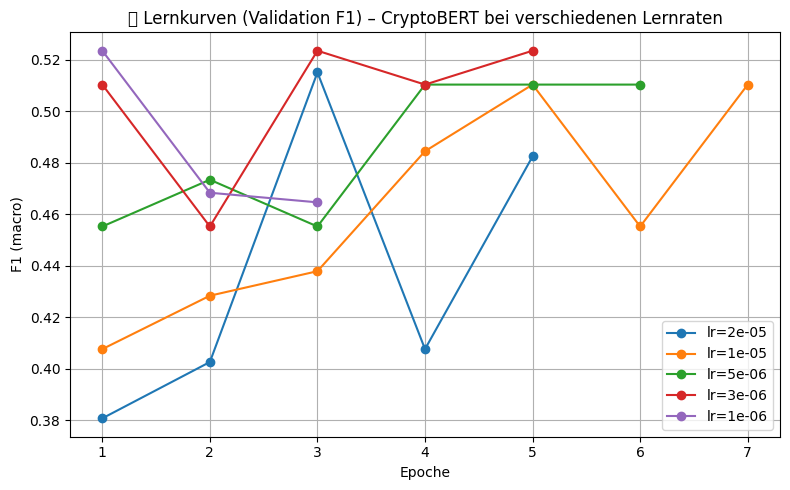

In [77]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – CryptoBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
for lr, res in results.items():
    print(f"lr={lr}: best_f1={res['best_f1']:.4f}")


lr=2e-05: best_f1=0.5151
lr=1e-05: best_f1=0.5104
lr=5e-06: best_f1=0.5104
lr=3e-06: best_f1=0.5235
lr=1e-06: best_f1=0.5235


In [79]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 3e-06 mit F1 = 0.5235


Evaluation im finalen Testsplit

In [80]:
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

# Vorhersage
test_results = best_trainer.predict(test_ds)

# Argmax → Vorhersageklassen
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_results.label_ids

# 🔁 Label-Mapping: CryptoBERT → eigene Labelstruktur
label_mapping = {2: 0, 1: 1, 0: 2}  # 0=neg → 2=bearish, 2=pos → 0=bullish
y_pred = [label_mapping[p] for p in y_pred]

# Hauptmetriken berechnen
f1_macro = f1_score(y_true, y_pred, average="macro")
kappa = cohen_kappa_score(y_true, y_pred)

# Ausgabe
print("\nEvaluation auf Testset:")
print("F1-Score (macro):", round(f1_macro, 4))
print("Cohen’s Kappa:   ", round(kappa, 4))
print("\nKlassifikationsreport:")
print(classification_report(y_true, y_pred))



Evaluation auf Testset:
F1-Score (macro): 0.3651
Cohen’s Kappa:    0.0911

Klassifikationsreport:
              precision    recall  f1-score   support

           0       0.33      0.17      0.22        18
           1       0.58      0.68      0.62        28
           2       0.21      0.30      0.25        10

    accuracy                           0.45        56
   macro avg       0.37      0.38      0.37        56
weighted avg       0.43      0.45      0.43        56



Falsche Vorhersagen

In [81]:
wrong = [(i, p, t) for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]
wrong_df = test_df.iloc[[i for i, _, _ in wrong]].copy()
wrong_df["predicted"] = [p for _, p, _ in wrong]
wrong_df["true"] = [t for _, _, t in wrong]

wrong_df[["text", "true", "predicted"]].head(10)


,text,true,predicted
2,Jesus dude even the haters on here back in the...,2,0
4,"Lmao yeah sure, if Kamala would have won, BTC ...",0,1
7,Nah.. im done chilling…Another excuse eh? What...,2,0
9,CGPT 🚀🚀,0,2
10,Yeah I bought the Pepe discount\n\nI hate pepe...,0,1
11,"That is also true, I think that is also due to...",2,1
13,Everything from gold to stocks are valued by s...,1,0
16,!topics,1,2
17,The pros in crypto are inversed,1,2
18,Why do the masses think they know better than ...,0,2
